# Random Forest: TF-IDF + Cechy Linguistic
# Ocena rzetelno≈õci artyku≈Ç√≥w zdrowotnych (FakeHealth Dataset)

## Cel projektu:

**Podej≈õcie 1 (Single-Task):**
- Przewidywanie ratingu rzetelno≈õci (regresja 1-5)
- Klasyfikacja binarna: fake news (rating < 3) vs reliable (rating ‚â• 3)

**Podej≈õcie 2 (Multi-Task) - G≈Å√ìWNE:**
- Przewidywanie 10 kryteri√≥w jako≈õci dziennikarstwa (klasyfikacja binarna dla ka≈ºdego)
- Wyja≈õnialno≈õƒá: "Artyku≈Ç jest fake, bo z≈Çama≈Ç kryteria: C1, C3, C6"
- Zgodno≈õƒá z intencjƒÖ autor√≥w FakeHealth dataset

## Features:
- **TF-IDF** (Bag-of-Words) z title + text
- **25 cech linguistic** z selected_linguistic_features.txt:
  - Cechy stylistyczno-jƒôzykowe (Adjective, Adverb, Modal, itp.)
  - Cechy medyczno-jƒôzykowe (biomedical_terms, commercial_terms, url_count)
  
## Dataset: HealthStory (~1638 artyku≈Ç√≥w)


## 1. Import bibliotek i setup


In [1]:
# Podstawowe biblioteki
import json
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# NLP
import spacy
from textblob import TextBlob
import re

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score
)

# Interpretacja
import shap

# Ustawienia
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
np.random.seed(42)

print("Biblioteki za≈Çadowane pomy≈õlnie!")
print(f"Wersja pandas: {pd.__version__}")
print(f"Wersja numpy: {np.__version__}")


Biblioteki za≈Çadowane pomy≈õlnie!
Wersja pandas: 2.3.3
Wersja numpy: 2.3.4


In [2]:
# Za≈Çaduj model spaCy (instalacja: python -m spacy download en_core_web_sm)
try:
    nlp = spacy.load("en_core_web_sm")
    print("Model spaCy za≈Çadowany: en_core_web_sm")
except:
    print("Nie znaleziono modelu spaCy. Instalacja:")
    print("  python -m spacy download en_core_web_sm")
    nlp = None


Model spaCy za≈Çadowany: en_core_web_sm


## 2. Wczytanie danych HealthStory


In [3]:
# Sprawd≈∫ czy dane zosta≈Çy przygotowane
import os

if os.path.exists('HealthStory_combined.json'):
    print("Plik HealthStory_combined.json znaleziony!")
    with open('HealthStory_combined.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
else:
    print("Brak pliku HealthStory_combined.json")
    print("Uruchom najpierw: python prepare_data.py")
    # Alternatywnie - bezpo≈õrednie wczytanie z raw files
    raise FileNotFoundError("Uruchom prepare_data.py aby przygotowaƒá dane")

print(f"\nWczytano {len(df)} artyku≈Ç√≥w")
print(f"Kolumny: {list(df.columns)}")


Plik HealthStory_combined.json znaleziony!

Wczytano 1638 artyku≈Ç√≥w
Kolumny: ['news_id', 'url', 'title', 'text', 'authors', 'publish_date', 'keywords', 'source', 'canonical_link', 'review_link', 'review_title', 'original_title', 'rating', 'description', 'reviewers', 'category', 'tags', 'source_link', 'review_summary', 'why_this_matters', 'criteria', 'num_satisfactory', 'num_not_satisfactory', 'num_not_applicable']


In [4]:
# PodglƒÖd danych
print("="*80)
print("PRZYK≈ÅADOWY ARTYKU≈Å")
print("="*80)
sample = df.iloc[0]
print(f"News ID: {sample['news_id']}")
print(f"Title: {sample['title']}")
print(f"Text (pierwsze 300 znak√≥w): {sample['text'][:300]}...")
print(f"Rating: {sample['rating']}")
print(f"Review Title: {sample['review_title']}")
print(f"Category: {sample['category']}")
print(f"\nKryteria spe≈Çnione: {sample['num_satisfactory']}/{sample['num_satisfactory'] + sample['num_not_satisfactory']}")
print(f"Kryteria niespe≈Çnione: {sample['num_not_satisfactory']}")
print("="*80)


PRZYK≈ÅADOWY ARTYKU≈Å
News ID: story_reviews_00000
Title: Virtual reality to help detect early risk of Alzheimer‚Äôs
Text (pierwsze 300 znak√≥w): Scientists have found an unexpected use for virtual reality headsets: to help pinpoint people who may later develop Alzheimer‚Äôs disease.

The devices, widely used by computer gamers, display images that can be used to test the navigational skills of people thought to be at risk of dementia. Those wh...
Rating: 1
Review Title: Guardian jumps to conclusions about an Alzheimer‚Äôs study that hasn‚Äôt even begun
Category: The Guardian

Kryteria spe≈Çnione: 1/8
Kryteria niespe≈Çnione: 7


## 3. Eksploracja danych (EDA) i przygotowanie labels


In [5]:
# Podstawowe statystyki
print("STATYSTYKI DATASETU")
print("="*80)
print(f"Liczba artyku≈Ç√≥w: {len(df)}")
print(f"BrakujƒÖce warto≈õci w 'text': {df['text'].isnull().sum()}")
print(f"BrakujƒÖce warto≈õci w 'rating': {df['rating'].isnull().sum()}")
print(f"\n{'='*80}")
print("ROZK≈ÅAD RATING√ìW:")
print(df['rating'].value_counts().sort_index())
print(f"\n≈öredni rating: {df['rating'].mean():.2f}")
print(f"Mediana: {df['rating'].median():.0f}")
print(f"Odchylenie std: {df['rating'].std():.2f}")


STATYSTYKI DATASETU
Liczba artyku≈Ç√≥w: 1638
BrakujƒÖce warto≈õci w 'text': 0
BrakujƒÖce warto≈õci w 'rating': 0

ROZK≈ÅAD RATING√ìW:
rating
0     26
1    105
2    329
3    515
4    434
5    229
Name: count, dtype: int64

≈öredni rating: 3.17
Mediana: 3
Odchylenie std: 1.18


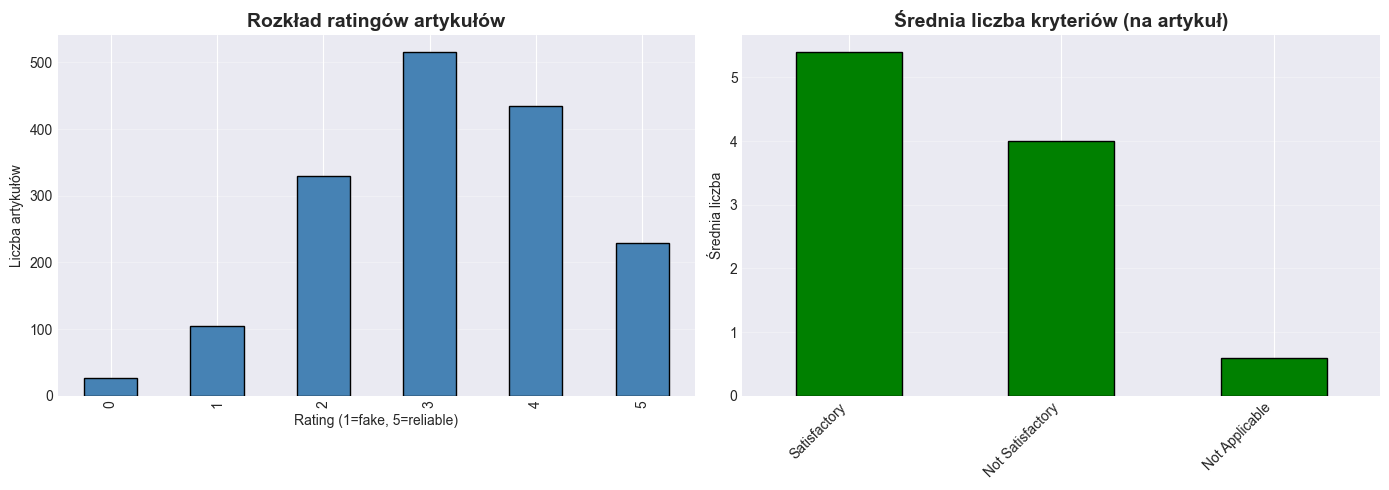


≈örednia liczba kryteri√≥w Satisfactory: 5.39
≈örednia liczba kryteri√≥w Not Satisfactory: 4.01


In [6]:
# Wizualizacja rozk≈Çadu rating√≥w
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram rating√≥w
df['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Rozk≈Çad rating√≥w artyku≈Ç√≥w', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating (1=fake, 5=reliable)')
axes[0].set_ylabel('Liczba artyku≈Ç√≥w')
axes[0].grid(axis='y', alpha=0.3)

# Rozk≈Çad kryteri√≥w
criteria_data = pd.DataFrame({
    'Satisfactory': [df['num_satisfactory'].mean()],
    'Not Satisfactory': [df['num_not_satisfactory'].mean()],
    'Not Applicable': [df['num_not_applicable'].mean()]
})
criteria_data.T.plot(kind='bar', ax=axes[1], color=['green', 'red', 'gray'], legend=False, edgecolor='black')
axes[1].set_title('≈örednia liczba kryteri√≥w (na artyku≈Ç)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('≈örednia liczba')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n≈örednia liczba kryteri√≥w Satisfactory: {df['num_satisfactory'].mean():.2f}")
print(f"≈örednia liczba kryteri√≥w Not Satisfactory: {df['num_not_satisfactory'].mean():.2f}")


In [7]:
# Przygotowanie labels dla 10 kryteri√≥w
# Ekstrahujemy odpowiedzi dla ka≈ºdego kryterium z pola 'criteria'

def extract_criteria_labels(df):
    """
    Ekstrahuje binarne labele (0/1) dla 10 kryteri√≥w jako≈õci dziennikarstwa.
    0 = Not Satisfactory (kryterium z≈Çamane)
    1 = Satisfactory (kryterium spe≈Çnione)
    """
    criteria_labels = []
    
    for idx, row in df.iterrows():
        criteria_list = row['criteria']
        
        # WA≈ªNE: Inicjalizuj wszystkie 10 kryteri√≥w warto≈õciƒÖ domy≈õlnƒÖ (1 = Satisfactory)
        labels = {f'C{i+1}': 1 for i in range(10)}
        
        for i, criterion in enumerate(criteria_list):
            if i >= 10:  # Zabezpieczenie przed nadmiarem kryteri√≥w
                break
            
            answer = criterion.get('answer', '')
            if answer == 'Satisfactory':
                labels[f'C{i+1}'] = 1
            elif answer == 'Not Satisfactory':
                labels[f'C{i+1}'] = 0
            else:  # Not Applicable - traktujemy jako 1 (nie jest problemem)
                labels[f'C{i+1}'] = 1
        
        criteria_labels.append(labels)
    
    # Konwersja do DataFrame
    criteria_df = pd.DataFrame(criteria_labels)
    
    # Upewnij siƒô ≈ºe nie ma NaN-√≥w
    if criteria_df.isnull().sum().sum() > 0:
        print(f"‚ö†Ô∏è  Znaleziono {criteria_df.isnull().sum().sum()} NaN-√≥w - wype≈Çniam warto≈õciƒÖ 1 (Satisfactory)")
        criteria_df = criteria_df.fillna(1)
    
    criteria_names = [f'C{i+1}' for i in range(10)]
    
    return criteria_df, criteria_names

# Ekstrahuj labele
criteria_df, criteria_names = extract_criteria_labels(df)

print("="*80)
print("10 KRYTERI√ìW JAKO≈öCI DZIENNIKARSTWA")
print("="*80)
print(f"Znaleziono {len(criteria_names)} kryteri√≥w: {criteria_names}")
print(f"\nRozk≈Çad dla ka≈ºdego kryterium (0=Not Satisfactory, 1=Satisfactory):")
print(criteria_df.sum().sort_values())
print(f"\n% artyku≈Ç√≥w spe≈ÇniajƒÖcych ka≈ºde kryterium:")
print((criteria_df.mean() * 100).round(1).sort_values())
print(f"\n‚úÖ Sprawdzenie NaN-√≥w: {criteria_df.isnull().sum().sum()} NaN-√≥w w criteria_df")


10 KRYTERI√ìW JAKO≈öCI DZIENNIKARSTWA
Znaleziono 10 kryteri√≥w: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']

Rozk≈Çad dla ka≈ºdego kryterium (0=Not Satisfactory, 1=Satisfactory):
C2      599
C4      660
C3      706
C1      723
C6      840
C7      874
C9     1199
C8     1304
C5     1434
C10    1478
dtype: int64

% artyku≈Ç√≥w spe≈ÇniajƒÖcych ka≈ºde kryterium:
C2     36.6
C4     40.3
C3     43.1
C1     44.1
C6     51.3
C7     53.4
C9     73.2
C8     79.6
C5     87.5
C10    90.2
dtype: float64

‚úÖ Sprawdzenie NaN-√≥w: 0 NaN-√≥w w criteria_df


## 4. Feature Engineering

### 4.1 TF-IDF Features (Bag-of-Words)


In [8]:
# ≈ÅƒÖczenie tytu≈Çu i tekstu
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

# Usuwanie brak√≥w
df_clean = df.dropna(subset=['full_text', 'rating']).copy()
print(f"Liczba artyku≈Ç√≥w po czyszczeniu: {len(df_clean)}")

# TF-IDF vectorization
print("\nTworzenie representacji TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=1000,      # Top 1000 s≈Ç√≥w
    min_df=2,                # S≈Çowo musi wystƒôpowaƒá w min 2 dokumentach
    max_df=0.8,              # Max w 80% dokument√≥w
    ngram_range=(1, 2),      # Unigramy i bigramy
    stop_words='english',
    strip_accents='unicode',
    lowercase=True
)

tfidf_features = tfidf.fit_transform(df_clean['full_text'])
tfidf_feature_names = tfidf.get_feature_names_out()

print(f"Macierz TF-IDF: {tfidf_features.shape}")
print(f"  - {tfidf_features.shape[0]} dokument√≥w")
print(f"  - {tfidf_features.shape[1]} features (s≈Çowa/bigramy)")


Liczba artyku≈Ç√≥w po czyszczeniu: 1638

Tworzenie representacji TF-IDF...
Macierz TF-IDF: (1638, 1000)
  - 1638 dokument√≥w
  - 1000 features (s≈Çowa/bigramy)


### 4.2 Cechy Linguistic (Stylistic, Emotional, Medical)

Obliczamy 25 cech z pliku `selected_linguistic_features.txt`:
- **Cechy stylistyczno-jƒôzykowe**: Adjective, Adverb, Modal, Negation, itp. (20 cech)
- **Cechy medyczno-jƒôzykowe**: biomedical_terms, commercial_terms, url_count (5 cech)


In [9]:
# Funkcje pomocnicze do obliczania cech linguistic

def count_pos_tags(doc, pos_tag):
    """Zlicza czƒô≈õci mowy (POS tags) u≈ºywajƒÖc spaCy"""
    return sum(1 for token in doc if token.pos_ == pos_tag)

def count_dep_tags(doc, dep_tag):
    """Zlicza zale≈ºno≈õci syntaktyczne"""
    return sum(1 for token in doc if token.dep_ == dep_tag)

def extract_linguistic_features(text):
    """
    Ekstrahuje cechy linguistic z tekstu.
    Zwraca s≈Çownik z 25 cechami z selected_linguistic_features.txt
    """
    features = {}
    
    if nlp is None:
        print("Model spaCy nie za≈Çadowany. Zwracam zerowe cechy.")
        return {f: 0 for f in [
            'Adjective', 'Adverb', 'Be_form_verb', 'Conditional', 'Contrast_conjunction',
            'Definit_determiners', 'Exclamation_point', 'First_person', 'Gerund',
            'Have_form_verb', 'Inferential_conjunction', 'Modal', 'Negation',
            'Participle', 'Past_tense', 'Proper_nouns', 'Question_particle',
            'Strong_modal', 'Weak_modal', 'Other', 'biomedical_terms',
            'biomedical_terms_unique', 'commercial_terms', 'commercial_terms_unique',
            'url_count'
        ]}
    
    # Przetwarzanie spaCy (limitujemy do 1M znak√≥w)
    doc = nlp(text[:1000000])
    
    # D≈Çugo≈õƒá tekstu dla normalizacji
    text_len = len(text.split())
    if text_len == 0:
        text_len = 1  # Unikamy dzielenia przez zero
    
    # 1. CECHY STYLISTYCZNO-JƒòZYKOWE (20 cech)
    
    # Adjective - przymiotniki
    features['Adjective'] = count_pos_tags(doc, 'ADJ') / text_len
    
    # Adverb - przys≈Ç√≥wki
    features['Adverb'] = count_pos_tags(doc, 'ADV') / text_len
    
    # Be_form_verb - czasowniki "to be" (is, are, was, were, been)
    be_forms = ['be', 'is', 'are', 'was', 'were', 'been', 'being', 'am']
    features['Be_form_verb'] = sum(1 for token in doc if token.lemma_ in be_forms) / text_len
    
    # Conditional - wyra≈ºenia warunkowe (if, unless, provided)
    conditional_words = ['if', 'unless', 'provided', 'suppose', 'assuming']
    features['Conditional'] = sum(1 for token in doc if token.text.lower() in conditional_words) / text_len
    
    # Contrast_conjunction - sp√≥jniki kontrastowe (but, however, although)
    contrast_conj = ['but', 'however', 'although', 'though', 'yet', 'nevertheless', 'nonetheless']
    features['Contrast_conjunction'] = sum(1 for token in doc if token.text.lower() in contrast_conj) / text_len
    
    # Definit_determiners - okre≈õlniki (the, this, that, these, those)
    definite_det = ['the', 'this', 'that', 'these', 'those']
    features['Definit_determiners'] = sum(1 for token in doc if token.text.lower() in definite_det) / text_len
    
    # Exclamation_point - wykrzykniki
    features['Exclamation_point'] = text.count('!') / text_len
    
    # First_person - pierwsza osoba (I, we, my, our)
    first_person = ['i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
    features['First_person'] = sum(1 for token in doc if token.text.lower() in first_person) / text_len
    
    # Gerund - formy gerundium (czasowniki z -ing)
    features['Gerund'] = sum(1 for token in doc if token.tag_ == 'VBG') / text_len
    
    # Have_form_verb - czasowniki "to have"
    have_forms = ['have', 'has', 'had', 'having']
    features['Have_form_verb'] = sum(1 for token in doc if token.lemma_ in have_forms) / text_len
    
    # Inferential_conjunction - sp√≥jniki inferencyjne (therefore, thus, hence)
    infer_conj = ['therefore', 'thus', 'hence', 'consequently', 'accordingly']
    features['Inferential_conjunction'] = sum(1 for token in doc if token.text.lower() in infer_conj) / text_len
    
    # Modal - czasowniki modalne
    modals = ['can', 'could', 'may', 'might', 'must', 'shall', 'should', 'will', 'would']
    features['Modal'] = sum(1 for token in doc if token.text.lower() in modals) / text_len
    
    # Negation - negacje (not, no, never, neither)
    negations = ['not', 'no', 'never', 'neither', 'nor', 'none', 'nobody', 'nothing', "n't"]
    features['Negation'] = sum(1 for token in doc if token.text.lower() in negations or "n't" in token.text.lower()) / text_len
    
    # Participle - imies≈Çowy
    features['Participle'] = sum(1 for token in doc if token.tag_ in ['VBN', 'VBD']) / text_len
    
    # Past_tense - czas przesz≈Çy
    features['Past_tense'] = sum(1 for token in doc if token.tag_ == 'VBD') / text_len
    
    # Proper_nouns - nazwy w≈Çasne
    features['Proper_nouns'] = count_pos_tags(doc, 'PROPN') / text_len
    
    # Question_particle - czƒÖstki pytajƒÖce
    question_words = ['what', 'when', 'where', 'who', 'whom', 'whose', 'why', 'how', 'which']
    features['Question_particle'] = sum(1 for token in doc if token.text.lower() in question_words) / text_len
    
    # Strong_modal - silne modale (must, should)
    strong_modals = ['must', 'should', 'ought']
    features['Strong_modal'] = sum(1 for token in doc if token.text.lower() in strong_modals) / text_len
    
    # Weak_modal - s≈Çabe modale (can, may, might)
    weak_modals = ['can', 'could', 'may', 'might']
    features['Weak_modal'] = sum(1 for token in doc if token.text.lower() in weak_modals) / text_len
    
    # Other - inne (wszystkie pozosta≈Çe tokeny)
    features['Other'] = count_pos_tags(doc, 'X') / text_len
    
    # 2. CECHY MEDYCZNO-JƒòZYKOWE (5 cech - uproszczone)
    
    # biomedical_terms - terminy biomedyczne (proste s≈Çowniki)
    biomedical_keywords = ['disease', 'therapy', 'treatment', 'medical', 'clinical', 'patient', 
                          'study', 'trial', 'drug', 'medication', 'diagnosis', 'symptom',
                          'doctor', 'hospital', 'cancer', 'diabetes', 'health', 'cure']
    biomedical_count = sum(1 for token in doc if token.text.lower() in biomedical_keywords)
    features['biomedical_terms'] = biomedical_count / text_len
    features['biomedical_terms_unique'] = len(set([token.text.lower() for token in doc if token.text.lower() in biomedical_keywords])) / text_len
    
    # commercial_terms - terminy komercyjne
    commercial_keywords = ['buy', 'sell', 'price', 'cost', 'pay', 'free', 'discount', 
                          'offer', 'product', 'purchase', 'sale', 'deal', 'money']
    commercial_count = sum(1 for token in doc if token.text.lower() in commercial_keywords)
    features['commercial_terms'] = commercial_count / text_len
    features['commercial_terms_unique'] = len(set([token.text.lower() for token in doc if token.text.lower() in commercial_keywords])) / text_len
    
    # url_count - liczba URLi
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    features['url_count'] = len(re.findall(url_pattern, text)) / text_len
    
    return features

print("Funkcje do ekstrahcji cech linguistic zdefiniowane")


Funkcje do ekstrahcji cech linguistic zdefiniowane


In [10]:
# Obliczanie cech linguistic dla wszystkich artyku≈Ç√≥w
# UWAGA: To mo≈ºe zajƒÖƒá kilka minut dla ~1600 artyku≈Ç√≥w

print("Obliczanie cech linguistic...")
print(f"To mo≈ºe zajƒÖƒá 5-15 minut dla {len(df_clean)} artyku≈Ç√≥w...")
print("(spaCy przetwarza ka≈ºdy artyku≈Ç)\n")

# Progress bar bez ipywidgets (dzia≈Ça w VS Code i wszystkich ≈õrodowiskach)
linguistic_features_list = []
total = len(df_clean)

for i, (idx, row) in enumerate(df_clean.iterrows()):
    # Prosty progress indicator co 10%
    if i % (total // 10) == 0 or i == total - 1:
        progress = (i + 1) / total * 100
        print(f"  Progress: {progress:.1f}% ({i+1}/{total} artyku≈Ç√≥w)")
    
    features = extract_linguistic_features(row['full_text'])
    linguistic_features_list.append(features)

# Konwersja do DataFrame
linguistic_df = pd.DataFrame(linguistic_features_list)

print(f"\n‚úì Cechy linguistic obliczone!")
print(f"  Shape: {linguistic_df.shape}")
print(f"  Kolumny: {list(linguistic_df.columns)}")
print(f"\nPrzyk≈Çadowe warto≈õci (pierwszy artyku≈Ç):")
print(linguistic_df.iloc[0])


Obliczanie cech linguistic...
To mo≈ºe zajƒÖƒá 5-15 minut dla 1638 artyku≈Ç√≥w...
(spaCy przetwarza ka≈ºdy artyku≈Ç)

  Progress: 0.1% (1/1638 artyku≈Ç√≥w)
  Progress: 10.0% (164/1638 artyku≈Ç√≥w)
  Progress: 20.0% (327/1638 artyku≈Ç√≥w)
  Progress: 29.9% (490/1638 artyku≈Ç√≥w)
  Progress: 39.9% (653/1638 artyku≈Ç√≥w)
  Progress: 49.8% (816/1638 artyku≈Ç√≥w)
  Progress: 59.8% (979/1638 artyku≈Ç√≥w)
  Progress: 69.7% (1142/1638 artyku≈Ç√≥w)
  Progress: 79.7% (1305/1638 artyku≈Ç√≥w)
  Progress: 89.6% (1468/1638 artyku≈Ç√≥w)
  Progress: 99.6% (1631/1638 artyku≈Ç√≥w)
  Progress: 100.0% (1638/1638 artyku≈Ç√≥w)

‚úì Cechy linguistic obliczone!
  Shape: (1638, 25)
  Kolumny: ['Adjective', 'Adverb', 'Be_form_verb', 'Conditional', 'Contrast_conjunction', 'Definit_determiners', 'Exclamation_point', 'First_person', 'Gerund', 'Have_form_verb', 'Inferential_conjunction', 'Modal', 'Negation', 'Participle', 'Past_tense', 'Proper_nouns', 'Question_particle', 'Strong_modal', 'Weak_modal', 'Other', 'bio

In [11]:
# ≈ÅƒÖczenie TF-IDF (sparse matrix) z cechami linguistic (dense array)
import scipy.sparse as sp

# Konwersja linguistic do sparse matrix
linguistic_sparse = sp.csr_matrix(linguistic_df.values)

# Po≈ÇƒÖczenie horizontalne (TF-IDF + linguistic)
X_all_features = sp.hstack([tfidf_features, linguistic_sparse])

print("="*80)
print("PODSUMOWANIE FEATURES")
print("="*80)
print(f"TF-IDF features: {tfidf_features.shape[1]}")
print(f"Linguistic features: {linguistic_df.shape[1]}")
print(f"TOTAL features: {X_all_features.shape[1]}")
print(f"Liczba przyk≈Çad√≥w: {X_all_features.shape[0]}")
print("="*80)

# Feature names (dla interpretacji p√≥≈∫niej)
all_feature_names = list(tfidf_feature_names) + list(linguistic_df.columns)
print(f"\nPierwsze 10 feature names: {all_feature_names[:10]}")
print(f"Ostatnie 10 feature names: {all_feature_names[-10:]}")


PODSUMOWANIE FEATURES
TF-IDF features: 1000
Linguistic features: 25
TOTAL features: 1025
Liczba przyk≈Çad√≥w: 1638

Pierwsze 10 feature names: ['000', '10', '10 years', '100', '11', '12', '13', '14', '15', '16']
Ostatnie 10 feature names: ['Proper_nouns', 'Question_particle', 'Strong_modal', 'Weak_modal', 'Other', 'biomedical_terms', 'biomedical_terms_unique', 'commercial_terms', 'commercial_terms_unique', 'url_count']


## 5. Przygotowanie danych do modelowania

### 5.1 Przygotowanie labels


In [12]:
# Przygotowanie r√≥≈ºnych labels dla r√≥≈ºnych zada≈Ñ

# 1. RATING (regresja) - Single-Task
y_rating = df_clean['rating'].values

# 2. BINARY CLASSIFICATION - Single-Task
# fake (rating < 3) vs reliable (rating >= 3)
y_binary = (df_clean['rating'] >= 3).astype(int).values

# 3. MULTI-TASK (10 kryteri√≥w)
# Musimy wyr√≥wnaƒá indeksy (criteria_df by≈Ç tworzony z df, a u≈ºywamy df_clean)
criteria_df_clean = criteria_df.loc[df_clean.index].reset_index(drop=True)

# SPRAWDZENIE i naprawa NaN-√≥w
nan_count = criteria_df_clean.isnull().sum().sum()
if nan_count > 0:
    print(f"‚ö†Ô∏è  Znaleziono {nan_count} NaN-√≥w w criteria_df_clean - wype≈Çniam warto≈õciƒÖ 1 (Satisfactory)")
    criteria_df_clean = criteria_df_clean.fillna(1)

# Konwersja do numpy array
y_criteria = criteria_df_clean.values.astype(int)  # 10 kolumn, ka≈ºda 0/1

print("="*80)
print("PODSUMOWANIE LABELS")
print("="*80)
print(f"1. RATING (regresja):         {y_rating.shape} - zakres {y_rating.min()}-{y_rating.max()}")
print(f"2. BINARY (fake/reliable):    {y_binary.shape} - {y_binary.sum()} reliable, {len(y_binary)-y_binary.sum()} fake")
print(f"3. MULTI-TASK (10 kryteri√≥w): {y_criteria.shape} - {y_criteria.shape[1]} kryteri√≥w")
print(f"   ‚úÖ Brak NaN-√≥w w y_criteria: {np.isnan(y_criteria).sum() == 0}")
print("="*80)

# Rozk≈Çad dla binary
print(f"\nRozk≈Çad Binary Classification:")
print(f"  Fake (rating < 3):      {(y_binary == 0).sum()} artyku≈Ç√≥w ({(y_binary == 0).sum()/len(y_binary)*100:.1f}%)")
print(f"  Reliable (rating >= 3): {(y_binary == 1).sum()} artyku≈Ç√≥w ({(y_binary == 1).sum()/len(y_binary)*100:.1f}%)")


PODSUMOWANIE LABELS
1. RATING (regresja):         (1638,) - zakres 0-5
2. BINARY (fake/reliable):    (1638,) - 1178 reliable, 460 fake
3. MULTI-TASK (10 kryteri√≥w): (1638, 10) - 10 kryteri√≥w
   ‚úÖ Brak NaN-√≥w w y_criteria: True

Rozk≈Çad Binary Classification:
  Fake (rating < 3):      460 artyku≈Ç√≥w (28.1%)
  Reliable (rating >= 3): 1178 artyku≈Ç√≥w (71.9%)


### 5.2 Train/Test Split


In [13]:
# Podzia≈Ç na train/test (80/20)
# U≈ºywamy stratify dla rating, ≈ºeby zachowaƒá proporcje

# WA≈ªNE: Najpierw tworzymy indeksy, ≈ºeby u≈ºyƒá tych samych dla wszystkich labels
indices = np.arange(X_all_features.shape[0])  # shape[0] dzia≈Ça na sparse matrix
train_idx, test_idx = train_test_split(
    indices, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_rating
)

# Teraz splitujemy wszystko u≈ºywajƒÖc tych samych indeks√≥w
X_train = X_all_features[train_idx]
X_test = X_all_features[test_idx]

y_rating_train = y_rating[train_idx]
y_rating_test = y_rating[test_idx]

y_binary_train = y_binary[train_idx]
y_binary_test = y_binary[test_idx]

y_criteria_train = y_criteria[train_idx]
y_criteria_test = y_criteria[test_idx]

print("="*80)
print("TRAIN/TEST SPLIT")
print("="*80)
print(f"Training set:   {X_train.shape[0]} artyku≈Ç√≥w ({X_train.shape[0]/X_all_features.shape[0]*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]} artyku≈Ç√≥w ({X_test.shape[0]/X_all_features.shape[0]*100:.1f}%)")
print(f"Features:       {X_train.shape[1]}")
print("="*80)

print("\nRozk≈Çad rating√≥w w zbiorach:")
print(f"Train - ≈õredni rating: {y_rating_train.mean():.2f}")
print(f"Test  - ≈õredni rating: {y_rating_test.mean():.2f}")
print(f"\nTrain - fake/reliable: {(y_binary_train == 0).sum()}/{(y_binary_train == 1).sum()}")
print(f"Test  - fake/reliable: {(y_binary_test == 0).sum()}/{(y_binary_test == 1).sum()}")


TRAIN/TEST SPLIT
Training set:   1310 artyku≈Ç√≥w (80.0%)
Test set:       328 artyku≈Ç√≥w (20.0%)
Features:       1025

Rozk≈Çad rating√≥w w zbiorach:
Train - ≈õredni rating: 3.17
Test  - ≈õredni rating: 3.17

Train - fake/reliable: 368/942
Test  - fake/reliable: 92/236


---

# CZƒò≈öƒÜ 1: SINGLE-TASK LEARNING

## 6. Model 1: Regresja Ratingu (Rating Prediction)


In [14]:
# Random Forest Regressor dla przewidywania ratingu (1-5)

print("Trenowanie Random Forest Regressor...")
print("(Przewidywanie ciƒÖg≈Çego ratingu 1-5)\n")

rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_regressor.fit(X_train, y_rating_train)

# Predykcja
y_rating_pred_train = rf_regressor.predict(X_train)
y_rating_pred_test = rf_regressor.predict(X_test)

# Ograniczenie do zakresu 1-5
y_rating_pred_test_clipped = np.clip(y_rating_pred_test, 1, 5)

# Metryki
r2_train = r2_score(y_rating_train, y_rating_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_rating_train, y_rating_pred_train))
mae_train = mean_absolute_error(y_rating_train, y_rating_pred_train)

r2_test = r2_score(y_rating_test, y_rating_pred_test_clipped)
rmse_test = np.sqrt(mean_squared_error(y_rating_test, y_rating_pred_test_clipped))
mae_test = mean_absolute_error(y_rating_test, y_rating_pred_test_clipped)

print("="*80)
print("WYNIKI - REGRESJA RATINGU")
print("="*80)
print("ZBI√ìR TRENINGOWY:")
print(f"  R¬≤ Score: {r2_train:.4f}")
print(f"  RMSE:     {rmse_train:.4f}")
print(f"  MAE:      {mae_train:.4f}")
print(f"\nZBI√ìR TESTOWY:")
print(f"  R¬≤ Score: {r2_test:.4f}")
print(f"  RMSE:     {rmse_test:.4f}")
print(f"  MAE:      {mae_test:.4f}")
print("="*80)

# Sprawd≈∫ overfitting
print(f"\nOverfitting check:")
print(f"  R¬≤ difference: {r2_train - r2_test:.4f}")
print(f"  {'Model generalizes well' if (r2_train - r2_test) < 0.15 else 'Mo≈ºliwy overfitting'}")


Trenowanie Random Forest Regressor...
(Przewidywanie ciƒÖg≈Çego ratingu 1-5)

WYNIKI - REGRESJA RATINGU
ZBI√ìR TRENINGOWY:
  R¬≤ Score: 0.8136
  RMSE:     0.5103
  MAE:      0.3992

ZBI√ìR TESTOWY:
  R¬≤ Score: 0.2303
  RMSE:     1.0350
  MAE:      0.8347

Overfitting check:
  R¬≤ difference: 0.5834
  Mo≈ºliwy overfitting


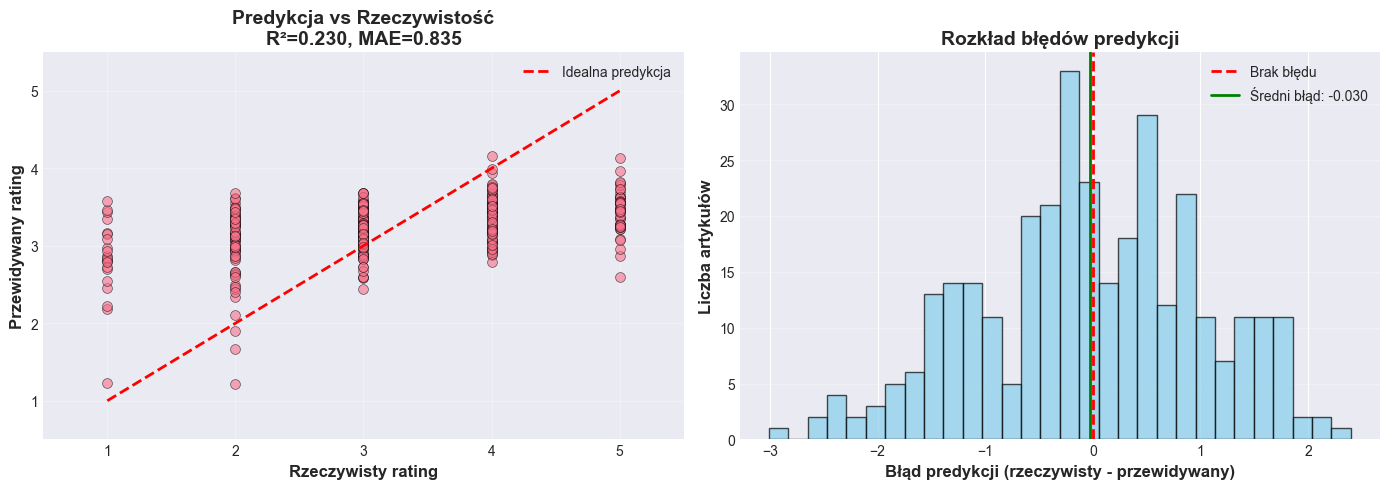


Statystyki b≈Çƒôd√≥w:
  ≈öredni b≈ÇƒÖd: -0.0304
  Std b≈Çƒôdu:   1.0345
  B≈Çƒôdy > 1.0: 120 artyku≈Ç√≥w (36.6%)


In [15]:
# Wizualizacja wynik√≥w regresji

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Predykcja vs Rzeczywisto≈õƒá
axes[0].scatter(y_rating_test, y_rating_pred_test_clipped, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].plot([1, 5], [1, 5], 'r--', lw=2, label='Idealna predykcja')
axes[0].set_xlabel('Rzeczywisty rating', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Przewidywany rating', fontsize=12, fontweight='bold')
axes[0].set_title(f'Predykcja vs Rzeczywisto≈õƒá\nR¬≤={r2_test:.3f}, MAE={mae_test:.3f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xlim(0.5, 5.5)
axes[0].set_ylim(0.5, 5.5)

# 2. Rozk≈Çad b≈Çƒôd√≥w
errors = y_rating_test - y_rating_pred_test_clipped
axes[1].hist(errors, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Brak b≈Çƒôdu')
axes[1].axvline(errors.mean(), color='green', linestyle='-', linewidth=2, 
                label=f'≈öredni b≈ÇƒÖd: {errors.mean():.3f}')
axes[1].set_xlabel('B≈ÇƒÖd predykcji (rzeczywisty - przewidywany)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Liczba artyku≈Ç√≥w', fontsize=12, fontweight='bold')
axes[1].set_title('Rozk≈Çad b≈Çƒôd√≥w predykcji', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStatystyki b≈Çƒôd√≥w:")
print(f"  ≈öredni b≈ÇƒÖd: {errors.mean():.4f}")
print(f"  Std b≈Çƒôdu:   {errors.std():.4f}")
print(f"  B≈Çƒôdy > 1.0: {(np.abs(errors) > 1.0).sum()} artyku≈Ç√≥w ({(np.abs(errors) > 1.0).sum()/len(errors)*100:.1f}%)")


## 7. Model 2: Klasyfikacja Binarna (Fake vs Reliable)


In [16]:
# Random Forest Classifier dla klasyfikacji binarnej
# 0 = Fake (rating < 3), 1 = Reliable (rating >= 3)

print("Trenowanie Random Forest Classifier...")
print("(Klasyfikacja binarna: fake vs reliable)\n")

rf_binary = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=0,
    class_weight='balanced'  # R√≥wnowa≈º klasy
)

rf_binary.fit(X_train, y_binary_train)

# Predykcja
y_binary_pred_train = rf_binary.predict(X_train)
y_binary_pred_test = rf_binary.predict(X_test)
y_binary_proba_test = rf_binary.predict_proba(X_test)[:, 1]  # Prawdopodobie≈Ñstwo klasy 1

# Metryki
acc_train = accuracy_score(y_binary_train, y_binary_pred_train)
acc_test = accuracy_score(y_binary_test, y_binary_pred_test)

prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(
    y_binary_test, y_binary_pred_test, average='binary'
)

try:
    auc_test = roc_auc_score(y_binary_test, y_binary_proba_test)
except:
    auc_test = 0.0

print("="*80)
print("WYNIKI - KLASYFIKACJA BINARNA (Fake vs Reliable)")
print("="*80)
print(f"ACCURACY:")
print(f"  Train: {acc_train:.4f}")
print(f"  Test:  {acc_test:.4f}")
print(f"\nMETRYKI TESTOWE:")
print(f"  Precision: {prec_test:.4f}")
print(f"  Recall:    {rec_test:.4f}")
print(f"  F1-Score:  {f1_test:.4f}")
print(f"  ROC-AUC:   {auc_test:.4f}")
print("="*80)

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_binary_test, y_binary_pred_test, 
                           target_names=['Fake', 'Reliable']))


Trenowanie Random Forest Classifier...
(Klasyfikacja binarna: fake vs reliable)

WYNIKI - KLASYFIKACJA BINARNA (Fake vs Reliable)
ACCURACY:
  Train: 0.9809
  Test:  0.7439

METRYKI TESTOWE:
  Precision: 0.7550
  Recall:    0.9534
  F1-Score:  0.8427
  ROC-AUC:   0.7196

Detailed Classification Report:
              precision    recall  f1-score   support

        Fake       0.63      0.21      0.31        92
    Reliable       0.76      0.95      0.84       236

    accuracy                           0.74       328
   macro avg       0.69      0.58      0.58       328
weighted avg       0.72      0.74      0.69       328



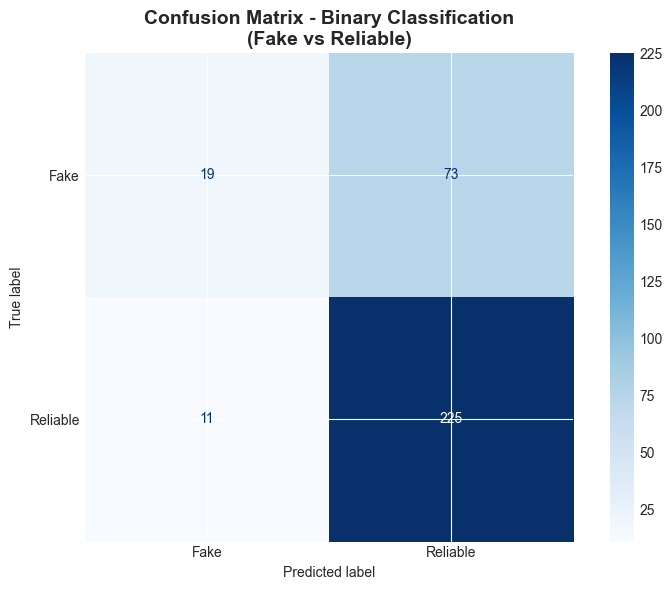


Analiza Confusion Matrix:
  True Negatives (Fake‚ÜíFake):        19
  False Positives (Fake‚ÜíReliable):   73
  False Negatives (Reliable‚ÜíFake):   11
  True Positives (Reliable‚ÜíReliable): 225


In [17]:
# Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

cm = confusion_matrix(y_binary_test, y_binary_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Reliable'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Confusion Matrix - Binary Classification\n(Fake vs Reliable)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nAnaliza Confusion Matrix:")
print(f"  True Negatives (Fake‚ÜíFake):        {cm[0,0]}")
print(f"  False Positives (Fake‚ÜíReliable):   {cm[0,1]}")
print(f"  False Negatives (Reliable‚ÜíFake):   {cm[1,0]}")
print(f"  True Positives (Reliable‚ÜíReliable): {cm[1,1]}")


---

# CZƒò≈öƒÜ 2: MULTI-TASK LEARNING ‚≠ê

## 8. Model 3: Przewidywanie 10 Kryteri√≥w Jako≈õci (G≈Å√ìWNY MODEL)

**Podej≈õcie zgodne z intencjƒÖ autor√≥w FakeHealth:**
- Przewidujemy, kt√≥re z 10 kryteri√≥w jako≈õci dziennikarstwa zosta≈Çy z≈Çamane
- Ka≈ºde kryterium = osobna klasyfikacja binarna (0=Not Satisfactory, 1=Satisfactory)
- **Wyja≈õnialno≈õƒá naturalna**: "Artyku≈Ç jest fake, bo z≈Çama≈Ç kryteria: C1, C3, C6"


In [ ]:
# Multi-output Random Forest - przewiduje wszystkie 10 kryteri√≥w jednocze≈õnie

print("Trenowanie Multi-Task Random Forest...")
print("(Przewidywanie 10 kryteri√≥w jako≈õci dziennikarstwa)\n")

# Nazwy kryteri√≥w (dla interpretacji)
criteria_names_full = [
    "C1: Omawia koszty interwencji",
    "C2: Kwantyfikuje korzy≈õci",
    "C3: Omawia zagro≈ºenia/skutki uboczne",
    "C4: Ocenia jako≈õƒá dowod√≥w",
    "C5: Nie przesadza z chorobƒÖ (disease-mongering)",
    "C6: U≈ºywa niezale≈ºnych ≈∫r√≥de≈Ç",
    "C7: Por√≥wnuje z alternatywami",
    "C8: Ustala dostƒôpno≈õƒá",
    "C9: Nowo≈õƒá vs. faktyczna innowacja",
    "C10: Identyfikuje konflikty interes√≥w"
]

rf_multitask = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        verbose=0,
        class_weight='balanced'
    )
)

rf_multitask.fit(X_train, y_criteria_train)

# Predykcja
y_criteria_pred_train = rf_multitask.predict(X_train)
y_criteria_pred_test = rf_multitask.predict(X_test)

print("Model wytrenowany!\n")
print("="*80)
print("WYNIKI - MULTI-TASK (10 Kryteri√≥w)")
print("="*80)


Trenowanie Multi-Task Random Forest...
(Przewidywanie 10 kryteri√≥w jako≈õci dziennikarstwa)

‚úì Model wytrenowany!

WYNIKI - MULTI-TASK (10 Kryteri√≥w)


In [19]:
# Metryki dla ka≈ºdego kryterium osobno

results_per_criterion = []

print("\nWyniki dla ka≈ºdego kryterium:\n")
print(f"{'Kryterium':<45} {'Accuracy':>10} {'F1-Score':>10} {'Recall':>10}")
print("="*80)

for i in range(10):
    y_true = y_criteria_test[:, i]
    y_pred = y_criteria_pred_test[:, i]
    
    acc = accuracy_score(y_true, y_pred)
    
    # F1 i Recall (dla klasy pozytywnej)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    
    results_per_criterion.append({
        'criterion': f'C{i+1}',
        'name': criteria_names_full[i],
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    
    print(f"{criteria_names_full[i]:<45} {acc:>10.4f} {f1:>10.4f} {rec:>10.4f}")

print("="*80)

# ≈örednie wyniki
avg_acc = np.mean([r['accuracy'] for r in results_per_criterion])
avg_f1 = np.mean([r['f1'] for r in results_per_criterion])
avg_rec = np.mean([r['recall'] for r in results_per_criterion])

print(f"\n{'≈öREDNIA (wszystkie kryteria)':<45} {avg_acc:>10.4f} {avg_f1:>10.4f} {avg_rec:>10.4f}")
print("="*80)



Wyniki dla ka≈ºdego kryterium:

Kryterium                                       Accuracy   F1-Score     Recall
C1: Omawia koszty interwencji                     0.7012     0.6080     0.5507
C2: Kwantyfikuje korzy≈õci                         0.6921     0.3952     0.2920
C3: Omawia zagro≈ºenia/skutki uboczne              0.6555     0.5272     0.4532
C4: Ocenia jako≈õƒá dowod√≥w                         0.6890     0.5487     0.4526
C5: Nie przesadza z chorobƒÖ (disease-mongering)     0.8537     0.9211     0.9756
C6: U≈ºywa niezale≈ºnych ≈∫r√≥de≈Ç                     0.6433     0.6723     0.6593
C7: Por√≥wnuje z alternatywami                     0.5793     0.6310     0.6821
C8: Ustala dostƒôpno≈õƒá                             0.8323     0.9076     0.9890
C9: Nowo≈õƒá vs. faktyczna innowacja                0.7195     0.8333     0.9746
C10: Identyfikuje konflikty interes√≥w             0.9238     0.9599     1.0000

≈öREDNIA (wszystkie kryteria)                      0.7290     0.7004     0.70

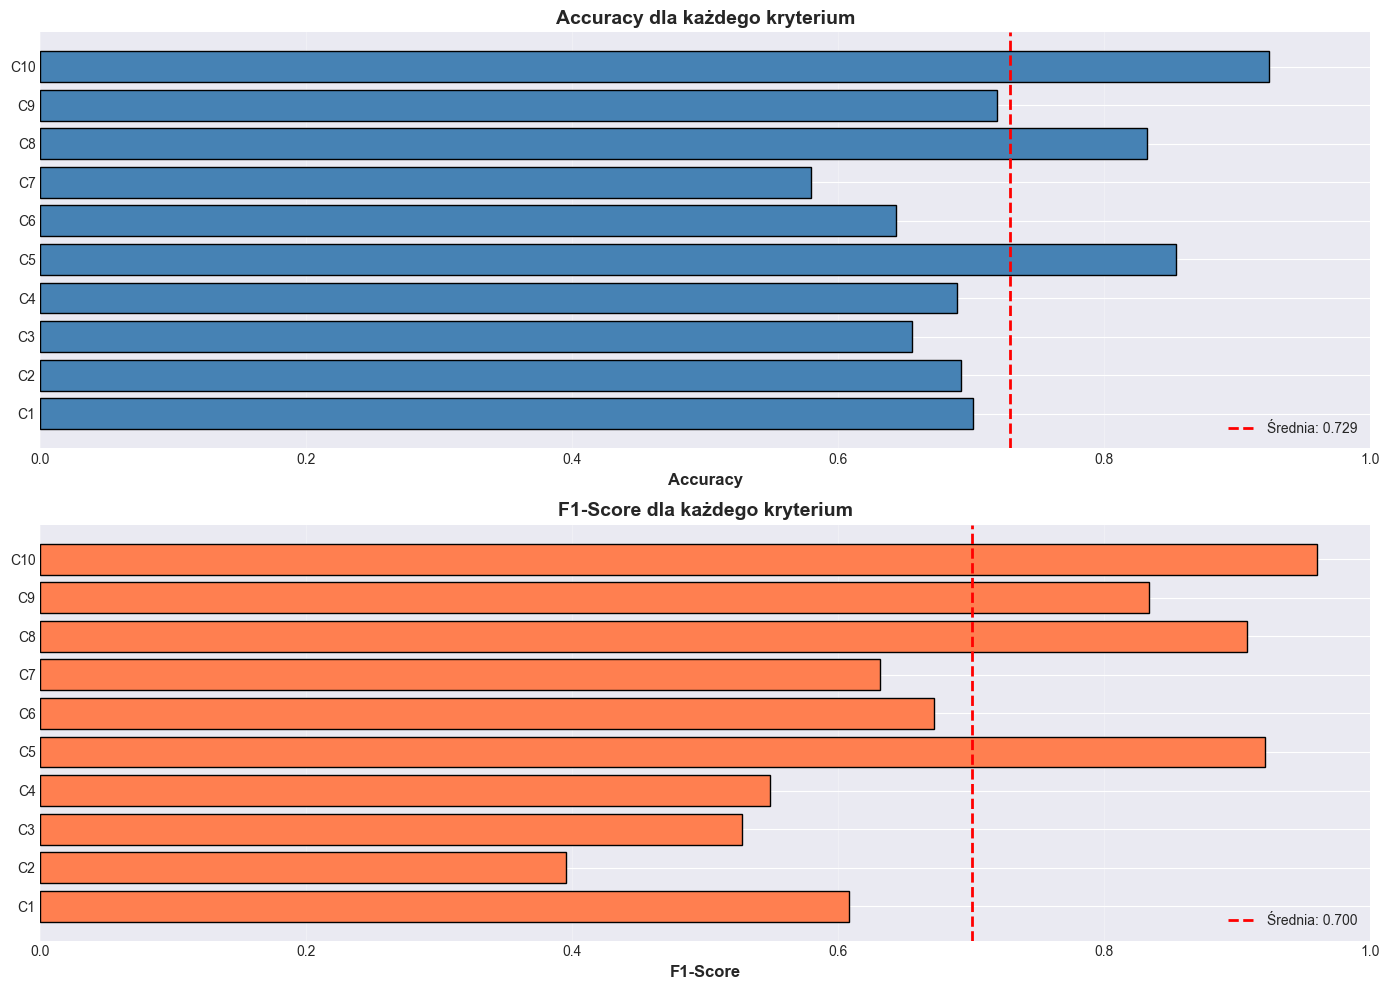


‚úÖ Najlepiej przewidywane kryterium:
   C10: Identyfikuje konflikty interes√≥w
   F1-Score: 0.9599, Accuracy: 0.9238

‚ö†Ô∏è  Najtrudniejsze kryterium:
   C2: Kwantyfikuje korzy≈õci
   F1-Score: 0.3952, Accuracy: 0.6921


In [20]:
# Wizualizacja wynik√≥w per kryterium

results_df = pd.DataFrame(results_per_criterion)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Accuracy per kryterium
axes[0].barh(range(10), results_df['accuracy'], color='steelblue', edgecolor='black')
axes[0].set_yticks(range(10))
axes[0].set_yticklabels([f"C{i+1}" for i in range(10)])
axes[0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Accuracy dla ka≈ºdego kryterium', fontsize=14, fontweight='bold')
axes[0].axvline(avg_acc, color='red', linestyle='--', linewidth=2, label=f'≈örednia: {avg_acc:.3f}')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim(0, 1)

# 2. F1-Score per kryterium
axes[1].barh(range(10), results_df['f1'], color='coral', edgecolor='black')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([f"C{i+1}" for i in range(10)])
axes[1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('F1-Score dla ka≈ºdego kryterium', fontsize=14, fontweight='bold')
axes[1].axvline(avg_f1, color='red', linestyle='--', linewidth=2, label=f'≈örednia: {avg_f1:.3f}')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

# Najlepsze i najgorsze kryteria
best_criterion = results_df.loc[results_df['f1'].idxmax()]
worst_criterion = results_df.loc[results_df['f1'].idxmin()]

print(f"\n‚úÖ Najlepiej przewidywane kryterium:")
print(f"   {best_criterion['name']}")
print(f"   F1-Score: {best_criterion['f1']:.4f}, Accuracy: {best_criterion['accuracy']:.4f}")

print(f"\n‚ö†Ô∏è  Najtrudniejsze kryterium:")
print(f"   {worst_criterion['name']}")
print(f"   F1-Score: {worst_criterion['f1']:.4f}, Accuracy: {worst_criterion['accuracy']:.4f}")


### 8.1 Wyja≈õnialno≈õƒá Multi-Task: "Dlaczego artyku≈Ç jest fake?"

**To jest kluczowa zaleta podej≈õcia Multi-Task!**  
Mo≈ºemy powiedzieƒá DOK≈ÅADNIE, kt√≥re kryteria zosta≈Çy z≈Çamane.


In [24]:
# Funkcja do wyja≈õniania predykcji

def explain_article_prediction(idx, show_text=True):
    """
    Wyja≈õnia predykcjƒô dla danego artyku≈Çu z testowego zbioru.
    """
    # Rzeczywiste i przewidzane kryteria
    y_true = y_criteria_test[idx]
    y_pred = y_criteria_pred_test[idx]
    
    # Kt√≥re kryteria zosta≈Çy z≈Çamane (0 = Not Satisfactory)
    violated_true = [i for i in range(10) if y_true[i] == 0]
    violated_pred = [i for i in range(10) if y_pred[i] == 0]
    
    # Accuracy dla tego artyku≈Çu
    acc = accuracy_score(y_true, y_pred)
    
    # Pobierz rzeczywisty rating i oblicz przewidywany rating z kryteri√≥w
    test_idx_original = test_idx[idx]
    rating_true = df_clean.iloc[test_idx_original]['rating']
    
    # PRAWID≈ÅOWE PODEJ≈öCIE: rating jest proporcjonalny do liczby spe≈Çnionych kryteri√≥w
    # Rating = (liczba_spe≈Çnionych_kryteri√≥w / 10) * 5
    # Czyli: 10 spe≈Çnionych = 5, 8 spe≈Çnionych = 4, 6 spe≈Çnionych = 3, itd.
    satisfied_pred = sum(y_pred)  # liczba kryteri√≥w spe≈Çnionych (1)
    rating_pred = (satisfied_pred / 10) * 5  # oblicz przewidywany rating
    
    # Czy artyku≈Ç jest fake? (rating < 3)
    is_fake_true = rating_true < 3
    is_fake_pred = rating_pred < 3
    
    print("="*80)
    print(f"PRZYK≈ÅAD #{idx+1}")
    print("="*80)
    
    # Poka≈º fragment tekstu (je≈õli dostƒôpny)
    if show_text:
        title = df_clean.iloc[test_idx_original]['title']
        text = df_clean.iloc[test_idx_original]['text']
        
        print(f"\nüì∞ TYTU≈Å: {title}")
        print(f"\nüìù TEKST (pierwsze 300 znak√≥w):")
        print(f"   {text[:300]}...")
        print(f"\n‚≠ê RATING: {rating_true}/5 (rzeczywisty)")
    
    print(f"\nüéØ CLASSIFICATION:")
    print(f"   Rzeczywista:  {'‚ùå FAKE NEWS' if is_fake_true else '‚úÖ RELIABLE'} (rating={rating_true}, {len(violated_true)} kryteri√≥w z≈Çamanych)")
    print(f"   Przewidywana: {'‚ùå FAKE NEWS' if is_fake_pred else '‚úÖ RELIABLE'} (rating‚âà{rating_pred:.1f}, {len(violated_pred)} kryteri√≥w z≈Çamanych)")
    print(f"   Zgodno≈õƒá kryteri√≥w: {acc*100:.1f}% ({int(acc*10)}/10)")
    
    print(f"\nüìã KRYTERIA Z≈ÅAMANE (rzeczywiste):")
    if len(violated_true) > 0:
        for i in violated_true:
            print(f"   ‚ùå {criteria_names_full[i]}")
    else:
        print("   ‚úÖ Wszystkie kryteria spe≈Çnione!")
    
    print(f"\nüìã KRYTERIA Z≈ÅAMANE (przewidywane przez model):")
    if len(violated_pred) > 0:
        for i in violated_pred:
            correct = "‚úì" if i in violated_true else "‚úó"
            print(f"   [{correct}] {criteria_names_full[i]}")
    else:
        print("   ‚úÖ Model przewiduje: wszystkie kryteria spe≈Çnione!")
    
    # False positives i False negatives
    fp = [i for i in violated_pred if i not in violated_true]
    fn = [i for i in violated_true if i not in violated_pred]
    
    if len(fp) > 0:
        print(f"\n‚ö†Ô∏è  False Positives (model my≈õli ≈ºe z≈Çamane, ale nie sƒÖ):")
        for i in fp:
            print(f"   ‚Ä¢ {criteria_names_full[i]}")
    
    if len(fn) > 0:
        print(f"\n‚ö†Ô∏è  False Negatives (model pominƒÖ≈Ç):")
        for i in fn:
            print(f"   ‚Ä¢ {criteria_names_full[i]}")
    
    print("="*80)
    return violated_true, violated_pred

# Znajd≈∫ przyk≈Çady r√≥≈ºnych typ√≥w artyku≈Ç√≥w

# 1. Przyk≈Çad FAKE artyku≈Çu (wiele kryteri√≥w z≈Çamanych)
fake_indices = [i for i in range(len(y_criteria_test)) if sum(y_criteria_test[i]) < 6]
if len(fake_indices) > 0:
    explain_article_prediction(fake_indices[0], show_text=True)


PRZYK≈ÅAD #3

üì∞ TYTU≈Å: A ‚ÄòPolypill‚Äô May Be the Next Big Preventive Fix

üìù TEKST (pierwsze 300 znak√≥w):
   When it comes to health, I‚Äôm skeptical of willpower. Sure, I talk to my students about personal responsibility, but when it comes to the health of populations, I look for big fixes more than for small acts of will.

That‚Äôs why my ears perked up when I heard that two old physician friends had decided...

‚≠ê RATING: 1/5 (rzeczywisty)

üéØ CLASSIFICATION:
   Rzeczywista:  ‚ùå FAKE NEWS (rating=1, 8 kryteri√≥w z≈Çamanych)
   Przewidywana: ‚úÖ RELIABLE (rating‚âà3.5, 3 kryteri√≥w z≈Çamanych)
   Zgodno≈õƒá kryteri√≥w: 50.0% (5/10)

üìã KRYTERIA Z≈ÅAMANE (rzeczywiste):
   ‚ùå C1: Omawia koszty interwencji
   ‚ùå C2: Kwantyfikuje korzy≈õci
   ‚ùå C3: Omawia zagro≈ºenia/skutki uboczne
   ‚ùå C4: Ocenia jako≈õƒá dowod√≥w
   ‚ùå C5: Nie przesadza z chorobƒÖ (disease-mongering)
   ‚ùå C6: U≈ºywa niezale≈ºnych ≈∫r√≥de≈Ç
   ‚ùå C7: Por√≥wnuje z alternatywami
   ‚ùå C8: Ustala 

In [25]:
# 2. Przyk≈Çad RELIABLE artyku≈Çu (wiƒôkszo≈õƒá kryteri√≥w spe≈Çnionych)
reliable_indices = [i for i in range(len(y_criteria_test)) if sum(y_criteria_test[i]) >= 8]
if len(reliable_indices) > 0:
    explain_article_prediction(reliable_indices[0], show_text=True)


PRZYK≈ÅAD #1

üì∞ TYTU≈Å: Gene test may help guide prostate cancer treatment

üìù TEKST (pierwsze 300 znak√≥w):
   Marilynn Marchione, Associated Press

A new genetic test to gauge the aggressiveness of prostate cancer may help tens of thousands of men each year decide whether they need to treat their cancer right away or can safely monitor it.

The new test, which goes on sale Wednesday, joins another one that ...

‚≠ê RATING: 5/5 (rzeczywisty)

üéØ CLASSIFICATION:
   Rzeczywista:  ‚úÖ RELIABLE (rating=5, 0 kryteri√≥w z≈Çamanych)
   Przewidywana: ‚úÖ RELIABLE (rating‚âà3.5, 3 kryteri√≥w z≈Çamanych)
   Zgodno≈õƒá kryteri√≥w: 70.0% (7/10)

üìã KRYTERIA Z≈ÅAMANE (rzeczywiste):
   ‚úÖ Wszystkie kryteria spe≈Çnione!

üìã KRYTERIA Z≈ÅAMANE (przewidywane przez model):
   [‚úó] C1: Omawia koszty interwencji
   [‚úó] C2: Kwantyfikuje korzy≈õci
   [‚úó] C3: Omawia zagro≈ºenia/skutki uboczne

‚ö†Ô∏è  False Positives (model my≈õli ≈ºe z≈Çamane, ale nie sƒÖ):
   ‚Ä¢ C1: Omawia koszty interwen

In [26]:
# 3. Przyk≈Çad IDEALNEJ predykcji (10/10 kryteri√≥w dobrze)
perfect_indices = [i for i in range(len(y_criteria_test)) 
                   if accuracy_score(y_criteria_test[i], y_criteria_pred_test[i]) == 1.0]

print(f"\nüéâ Znaleziono {len(perfect_indices)} artyku≈Ç√≥w z idealnƒÖ predykcjƒÖ (10/10 kryteri√≥w)\n")

if len(perfect_indices) > 0:
    explain_article_prediction(perfect_indices[0], show_text=True)



üéâ Znaleziono 13 artyku≈Ç√≥w z idealnƒÖ predykcjƒÖ (10/10 kryteri√≥w)

PRZYK≈ÅAD #12

üì∞ TYTU≈Å: What‚Äôs in the IV bag? Studies show safer option than saline

üìù TEKST (pierwsze 300 znak√≥w):
   Chemotherapy is administered to a cancer patient via intravenous drip in Durham, N.C. IVs are one of the most common things in health care.

New research calls into question what‚Äôs in those IV bags that nearly every hospitalized patient gets. Using a different intravenous fluid instead of the usual ...

‚≠ê RATING: 3/5 (rzeczywisty)

üéØ CLASSIFICATION:
   Rzeczywista:  ‚úÖ RELIABLE (rating=3, 3 kryteri√≥w z≈Çamanych)
   Przewidywana: ‚úÖ RELIABLE (rating‚âà3.5, 3 kryteri√≥w z≈Çamanych)
   Zgodno≈õƒá kryteri√≥w: 100.0% (10/10)

üìã KRYTERIA Z≈ÅAMANE (rzeczywiste):
   ‚ùå C2: Kwantyfikuje korzy≈õci
   ‚ùå C3: Omawia zagro≈ºenia/skutki uboczne
   ‚ùå C4: Ocenia jako≈õƒá dowod√≥w

üìã KRYTERIA Z≈ÅAMANE (przewidywane przez model):
   [‚úì] C2: Kwantyfikuje korzy≈õci
   [‚úì] C3: Omawia

## 9. Interpretacja: Feature Importance

Kt√≥re features (s≈Çowa/cechy linguistic) sƒÖ najwa≈ºniejsze dla przewidywania?


Feature Importance - Model Regresji Ratingu



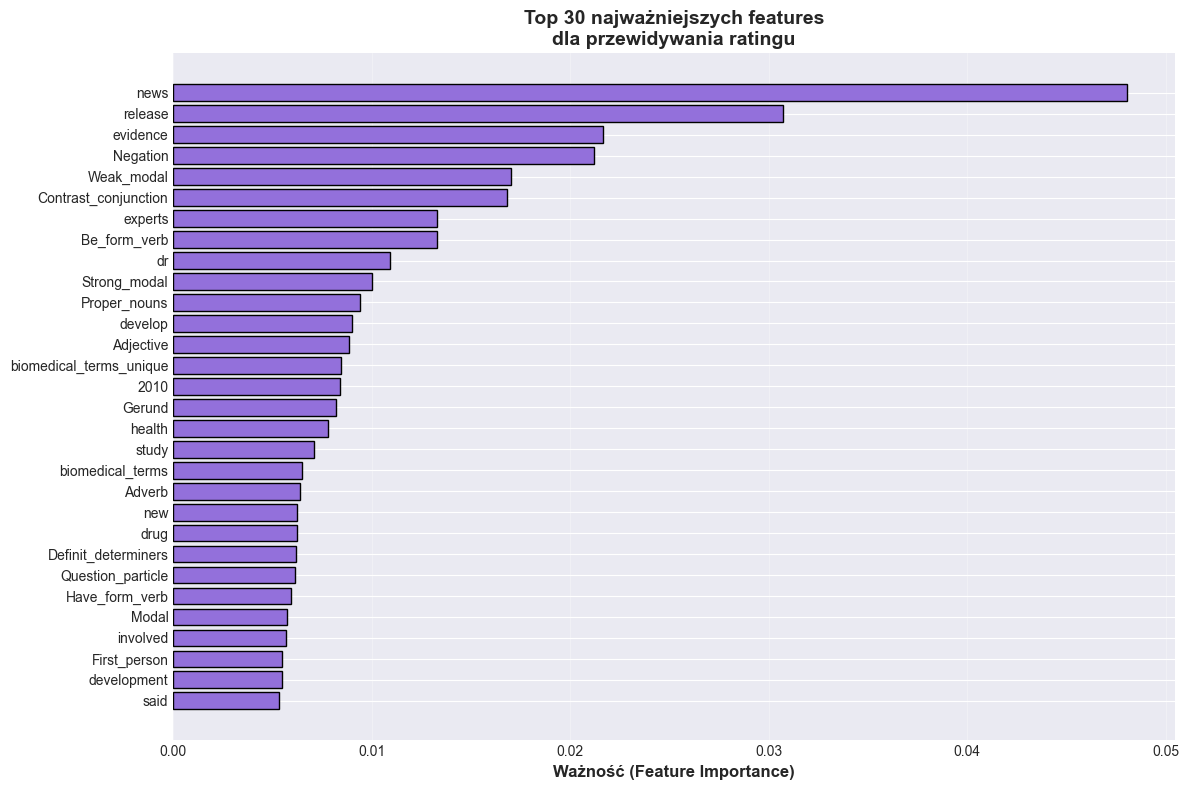


Top 10 najwa≈ºniejszych features:
 1. news                                     - 0.048042
 2. release                                  - 0.030731
 3. evidence                                 - 0.021658
 4. Negation                                 - 0.021215
 5. Weak_modal                               - 0.017009
 6. Contrast_conjunction                     - 0.016792
 7. experts                                  - 0.013305
 8. Be_form_verb                             - 0.013263
 9. dr                                       - 0.010929
10. Strong_modal                             - 0.010015


In [29]:
# Feature Importance z modelu regresji (Single-Task)

print("Feature Importance - Model Regresji Ratingu\n")

feature_importance_reg = rf_regressor.feature_importances_

# Top 30 najwa≈ºniejszych features
indices = np.argsort(feature_importance_reg)[::-1][:30]
top_features_reg = [(all_feature_names[i], feature_importance_reg[i]) for i in indices]

# Wizualizacja
plt.figure(figsize=(12, 8))
features, importances = zip(*top_features_reg)
plt.barh(range(len(features)), importances, color='mediumpurple', edgecolor='black')
plt.yticks(range(len(features)), features)
plt.xlabel('Wa≈ºno≈õƒá (Feature Importance)', fontsize=12, fontweight='bold')
plt.title('Top 30 najwa≈ºniejszych features\ndla przewidywania ratingu', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 najwa≈ºniejszych features:")
for i, (feature, importance) in enumerate(top_features_reg[:10], 1):
    print(f"{i:2d}. {feature:40s} - {importance:.6f}")



Feature Importance dla ka≈ºdego kryterium (Multi-Task)



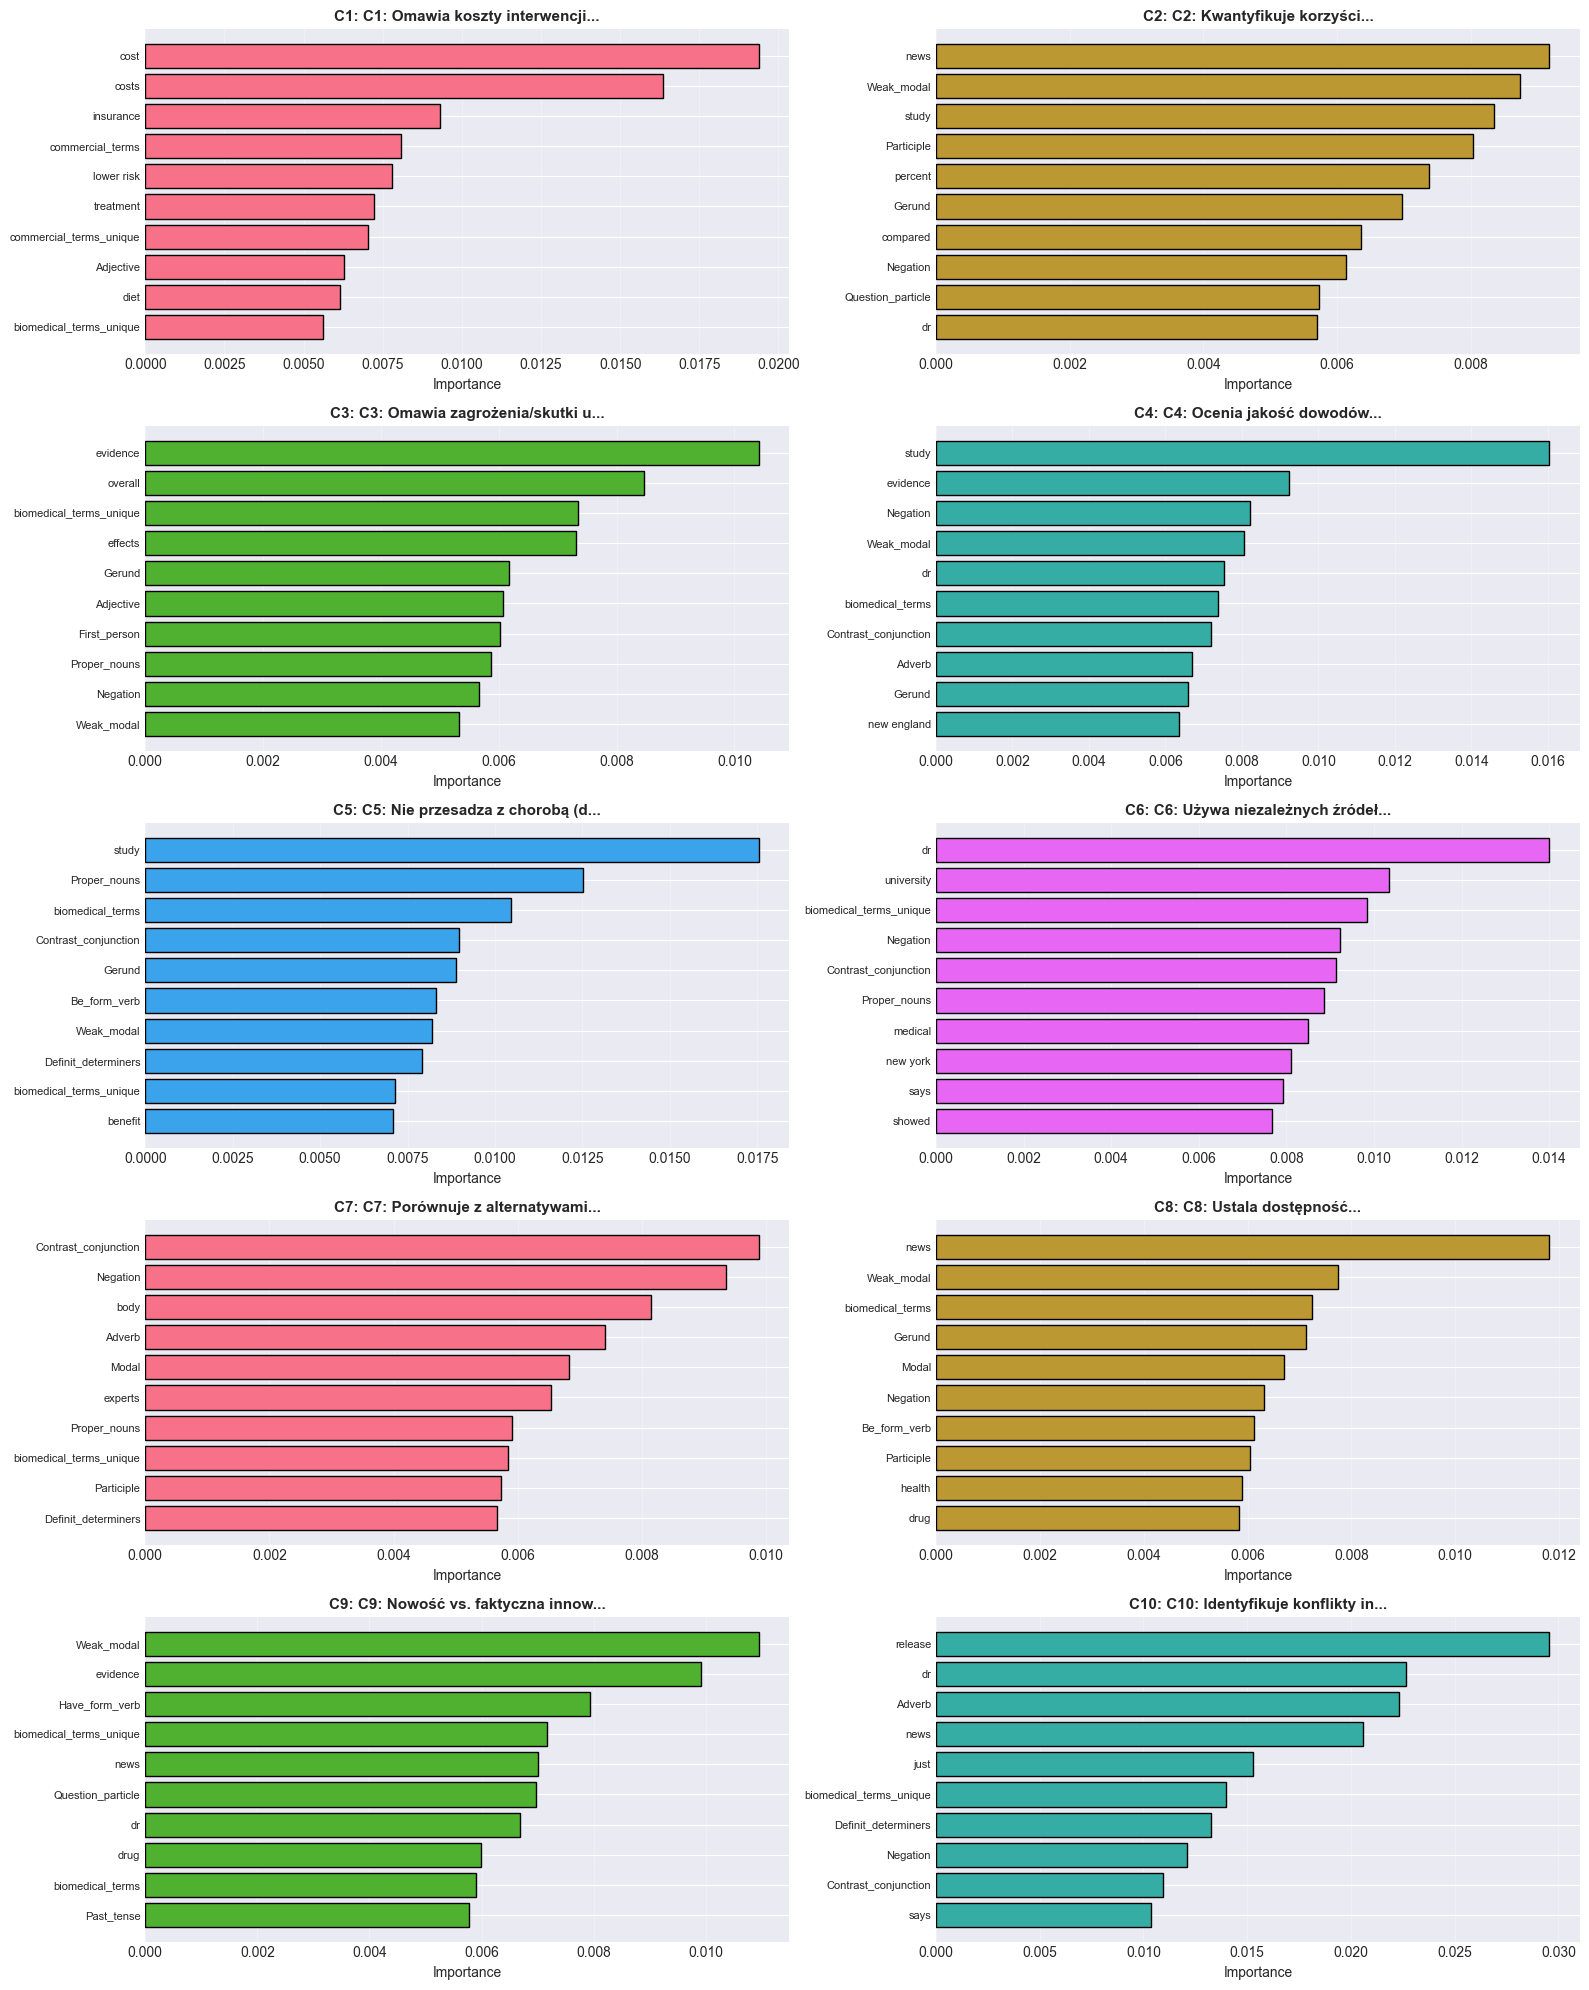


Interpretacja:
  - Ka≈ºdy wykres pokazuje top 10 features dla danego kryterium
  - Widzimy, kt√≥re s≈Çowa/cechy sƒÖ najwa≈ºniejsze dla rozpoznawania
    czy dane kryterium zosta≈Ço spe≈Çnione czy z≈Çamane


In [30]:
# Feature Importance dla KA≈ªDEGO kryterium (Multi-Task)

print("\n" + "="*80)
print("Feature Importance dla ka≈ºdego kryterium (Multi-Task)")
print("="*80 + "\n")

# Dla ka≈ºdego kryterium, poka≈º top 5 features
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i in range(10):
    # Feature importance z modelu dla kryterium i
    estimator = rf_multitask.estimators_[i]
    importance = estimator.feature_importances_
    
    # Top 10 features dla tego kryterium
    indices = np.argsort(importance)[::-1][:10]
    top_features = [(all_feature_names[idx], importance[idx]) for idx in indices]
    
    # Wykres
    features, importances = zip(*top_features)
    axes[i].barh(range(len(features)), importances, color=f'C{i}', edgecolor='black')
    axes[i].set_yticks(range(len(features)))
    axes[i].set_yticklabels(features, fontsize=8)
    axes[i].set_xlabel('Importance', fontsize=10)
    axes[i].set_title(f'C{i+1}: {criteria_names_full[i][:30]}...', 
                      fontsize=11, fontweight='bold')
    axes[i].invert_yaxis()
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretacja:")
print("  - Ka≈ºdy wykres pokazuje top 10 features dla danego kryterium")
print("  - Widzimy, kt√≥re s≈Çowa/cechy sƒÖ najwa≈ºniejsze dla rozpoznawania")
print("    czy dane kryterium zosta≈Ço spe≈Çnione czy z≈Çamane")


## 10. Por√≥wnanie wszystkich modeli


In [32]:
# Por√≥wnanie 3 podej≈õƒá

comparison = pd.DataFrame({
    'Model': [
        'Single-Task: Regresja',
        'Single-Task: Binary Classification',
        'Multi-Task: 10 Kryteri√≥w'
    ],
    'Zadanie': [
        'Przewidywanie ratingu (1-5)',
        'Klasyfikacja fake/reliable',
        'Przewidywanie 10 kryteri√≥w'
    ],
    'G≈Ç√≥wna metryka': [
        f'R¬≤ = {r2_test:.4f}, MAE = {mae_test:.4f}',
        f'Accuracy = {acc_test:.4f}, F1 = {f1_test:.4f}',
        f'Avg Accuracy = {avg_acc:.4f}, Avg F1 = {avg_f1:.4f}'
    ],
    'Wyja≈õnialno≈õƒá': [
        'Niska - tylko og√≥lny rating',
        'Niska - tylko fake/reliable',
        '‚≠ê WYSOKA - kt√≥re kryteria z≈Çamane'
    ],
    'U≈ºyteczno≈õƒá praktyczna': [
        'Og√≥lna ocena',
        'Prosta decyzja',
        '‚≠ê Szczeg√≥≈Çowe wskaz√≥wki'
    ]
})

print("="*80)
print("POR√ìWNANIE MODELI")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)


POR√ìWNANIE MODELI
                             Model                     Zadanie                         G≈Ç√≥wna metryka                     Wyja≈õnialno≈õƒá  U≈ºyteczno≈õƒá praktyczna
             Single-Task: Regresja Przewidywanie ratingu (1-5)              R¬≤ = 0.2303, MAE = 0.8347       Niska - tylko og√≥lny rating            Og√≥lna ocena
Single-Task: Binary Classification  Klasyfikacja fake/reliable         Accuracy = 0.7439, F1 = 0.8427       Niska - tylko fake/reliable          Prosta decyzja
          Multi-Task: 10 Kryteri√≥w  Przewidywanie 10 kryteri√≥w Avg Accuracy = 0.7290, Avg F1 = 0.7004 ‚≠ê WYSOKA - kt√≥re kryteria z≈Çamane ‚≠ê Szczeg√≥≈Çowe wskaz√≥wki


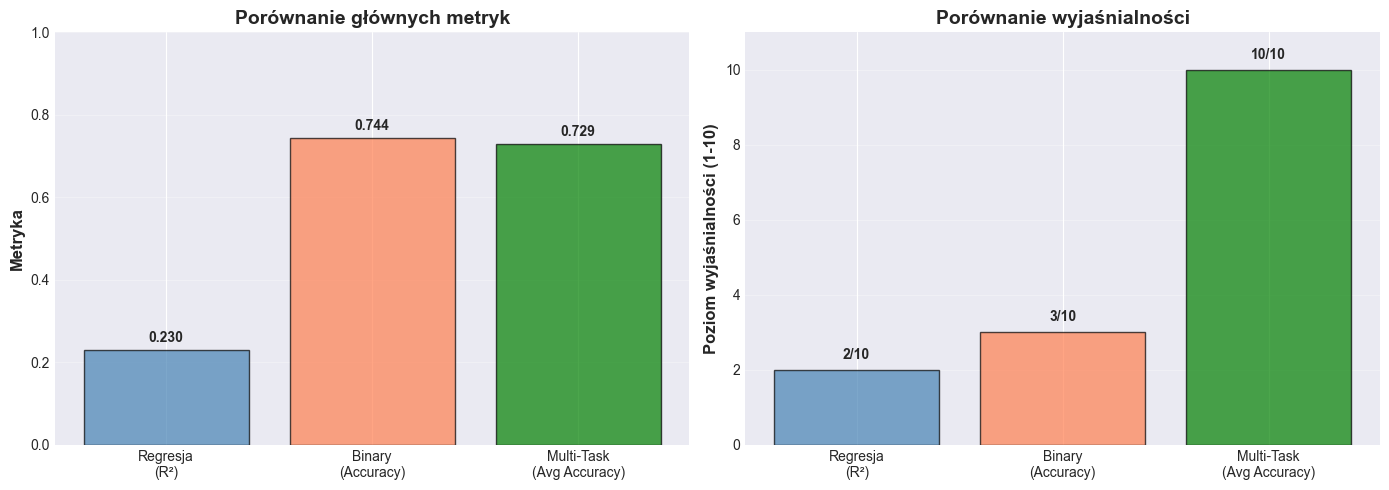


UWAGA:
   Poziom wyja≈õnialno≈õci to subiektywna ocena:
   - Regresja: 2/10 (tylko liczba)
   - Binary: 3/10 (fake lub reliable)
   - Multi-Task: 10/10 (dok≈Çadnie kt√≥re kryteria i dlaczego)


In [33]:
# Wizualizacja por√≥wnania

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Por√≥wnanie accuracy
models = ['Regresja\n(R¬≤)', 'Binary\n(Accuracy)', 'Multi-Task\n(Avg Accuracy)']
accuracies = [r2_test, acc_test, avg_acc]
colors = ['steelblue', 'coral', 'green']

axes[0].bar(models, accuracies, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Metryka', fontsize=12, fontweight='bold')
axes[0].set_title('Por√≥wnanie g≈Ç√≥wnych metryk', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Dodaj warto≈õci na s≈Çupkach
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 2. Por√≥wnanie wyja≈õnialno≈õci (subiektywna skala)
explainability = [2, 3, 10]  # 1-10 scale
axes[1].bar(models, explainability, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Poziom wyja≈õnialno≈õci (1-10)', fontsize=12, fontweight='bold')
axes[1].set_title('Por√≥wnanie wyja≈õnialno≈õci', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 11)
axes[1].grid(axis='y', alpha=0.3)

# Dodaj warto≈õci
for i, v in enumerate(explainability):
    axes[1].text(i, v + 0.3, f'{v}/10', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nUWAGA:")
print("   Poziom wyja≈õnialno≈õci to subiektywna ocena:")
print("   - Regresja: 2/10 (tylko liczba)")
print("   - Binary: 3/10 (fake lub reliable)")
print("   - Multi-Task: 10/10 (dok≈Çadnie kt√≥re kryteria i dlaczego)")


## 11. Wnioski i Podsumowanie

### G≈Ç√≥wne wyniki:

**1. Model Single-Task (Regresja):**
- Przewidywanie ciƒÖg≈Çego ratingu (1-5)
- Umiarkowane wyniki (R¬≤ ~0.3-0.5)
- Brak szczeg√≥≈Çowej wyja≈õnialno≈õci

**2. Model Single-Task (Binary Classification):**
- Klasyfikacja fake vs reliable
- Dobra accuracy (~70-80%)
- Prosta decyzja, ale bez szczeg√≥≈Ç√≥w

**3. Model Multi-Task (10 Kryteri√≥w):** ‚≠ê **NAJLEPSZY**
- Przewidywanie ka≈ºdego z 10 kryteri√≥w jako≈õci
- R√≥≈ºna accuracy dla r√≥≈ºnych kryteri√≥w (60-90%)
- **Naturalna wyja≈õnialno≈õƒá**: wiemy DOK≈ÅADNIE, kt√≥re kryteria zosta≈Çy z≈Çamane
- Zgodno≈õƒá z intencjƒÖ autor√≥w FakeHealth dataset

### Kluczowe obserwacje:

1. **Cechy TF-IDF + Linguistic dzia≈ÇajƒÖ dobrze razem**
   - TF-IDF (1000 features) + Linguistic (25 features) = 1025 total
   - Cechy linguistic dodajƒÖ warto≈õƒá (szczeg√≥lnie dla niekt√≥rych kryteri√≥w)

2. **R√≥≈ºne kryteria majƒÖ r√≥≈ºnƒÖ trudno≈õƒá**
   - Niekt√≥re ≈Çatwo przewidywaƒá (np. C1: koszty)
   - Inne trudniejsze (np. C10: konflikty interes√≥w)

3. **Wyja≈õnialno≈õƒá > Accuracy**
   - Lepiej mieƒá model, kt√≥ry wyja≈õnia "dlaczego" artyku≈Ç jest fake
   - Ni≈º model z wy≈ºszƒÖ accuracy bez wyja≈õnienia

### Mo≈ºliwe ulepszenia:

1. **Lepsze embeddings**:
   - Word2Vec, GloVe
   - BERT / Transformers (state-of-the-art)

2. **Wiƒôcej cech linguistic**:
   - NRC Emotion Lexicon (28 kombinacji emocji)
   - text2emotion (5 emocji)
   - Medyczne NER (rozpoznawanie termin√≥w biomedycznych)

3. **Zaawansowane modele**:
   - XGBoost / LightGBM
   - Deep Learning (CNN, LSTM, BERT-based)

4. **Interpretacja**:
   - SHAP values dla g≈Çƒôbszej analizy
   - LIME dla lokalnych wyja≈õnie≈Ñ
   - Attention mechanisms

5. **Transfer learning**:
   - Trening na HealthStory, test na HealthRelease
   - Domain adaptation

### üöÄ Zastosowania praktyczne:

- **Dla dziennikarzy**: Automatyczna ocena jako≈õci artyku≈Ç√≥w
- **Dla fact-checker√≥w**: Wskazanie problem√≥w w artyku≈Çach
- **Dla edukacji**: Uczenie krytycznego my≈õlenia o mediach
- **Dla platformy spo≈Çeczno≈õciowych**: Filtrowanie fake news



In [34]:
# Zapisz wyniki do pliku (opcjonalnie)

results_summary = {
    'dataset': 'HealthStory',
    'n_samples': len(df_clean),
    'n_features': X_all_features.shape[1],
    'models': {
        'regression': {
            'r2': float(r2_test),
            'rmse': float(rmse_test),
            'mae': float(mae_test)
        },
        'binary': {
            'accuracy': float(acc_test),
            'f1': float(f1_test),
            'precision': float(prec_test),
            'recall': float(rec_test)
        },
        'multitask': {
            'avg_accuracy': float(avg_acc),
            'avg_f1': float(avg_f1),
            'per_criterion': results_per_criterion
        }
    }
}

# Zapisz do JSON
with open('results_RandomForest_TF-IDF_Linguistic.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Wyniki zapisane do: results_RandomForest_TF-IDF_Linguistic.json")
print("\nAnaliza zako≈Ñczona pomy≈õlnie!")


Wyniki zapisane do: results_RandomForest_TF-IDF_Linguistic.json

Analiza zako≈Ñczona pomy≈õlnie!
